# Feature Extraction and Image Processing
Mark S. Nixon & Alberto S. Aguado http://www.southampton.ac.uk/~msn/book/
### Chapter 6: *HoughTransform*
Line detection by the Hough transform 
***  

### Setup modules

In [1]:
import os
import sys
sys.path.append(os.path.join(os.path.dirname("__file__"), "../../Modules"))

# Module functions
from ImageUtilities import imageReadL, createImageF, plotImageF, plotImageL, createScaleImageL
from ImageOperatorsUtilities import applyCannyEdgeDetector
from ImagePropertiesUtilities import imageMaxMin, peakDetectorImageL 
from PlotUtilities import plot3DHistogram 

# Math and iteration
from math import pi, tan
from timeit import itertools

### Parameters:
    pathToDir = Input image directory
    imageName = Input image name
    gaussianKernelSize = Gaussian kernel size. Filter noise
    sobelKernelSize = Sobel kernel size. Edge detection
    upperT = Upper threshold
    lowerT = Lower threshold
    peakDetection = Percentage of the maximum peak value that is considered for threshold

In [2]:
pathToDir = os.path.join(os.path.dirname("__file__"), "../../Images/Chapter6/Input/")
imageName = "Road.png"
gaussianKernelSize = 7
sobelKernelSize = 3
upperT = 0.5
lowerT = 0.3
peakDetection = 0.7

### Read and show input image

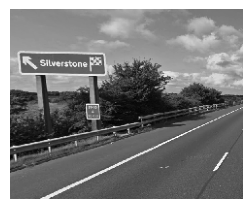

In [3]:
inputImage, width, height = imageReadL(pathToDir + imageName)
plotImageL(inputImage, figureSize = 3)

### Compute edges

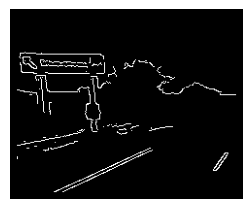

In [4]:
magnitude, angle = applyCannyEdgeDetector(inputImage, gaussianKernelSize, sobelKernelSize, upperT, lowerT)
plotImageF(magnitude,figureSize = 3)

### Gather evidence 

In [5]:
# Two accumulators, for horizontal and vertical lines. Each one stores a range of 90 degrees
# The intersection c corresponds to the intersections with the lines x=0 and y=0 
accHorizontal = createImageF(2*height,90)
accVertical = createImageF(2*width,90);

for x,y in itertools.product(range(0, width), range(0, height)):
    if magnitude[y,x] != 0:
        for m in range(0,90):
            
            # Lines between -45 and 45 degrees
            angle = ((-45 + m) * pi) / 180.0
            c = y - tan(angle) * x
            bucket = int(c)
            if bucket> 0 and bucket < 2*height - 1:
                weight = c - int(c)
                accHorizontal[m, bucket] += (1.0 - weight)
                accHorizontal[m, bucket+1] += weight
            
            # Lines between 45 and 135 degrees
            angle = ((45.0 + m) * pi) / 180.0
            c = x - y / tan(angle)
            bucket = int(c)
            if bucket> 0 and bucket < 2*width - 1:
                weight = c - int(c)
                accVertical[m, bucket] += (1.0 - weight)
                accVertical[m, bucket+1] += weight
  

### Plot accumulators

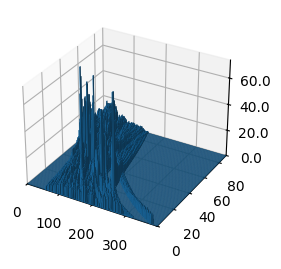

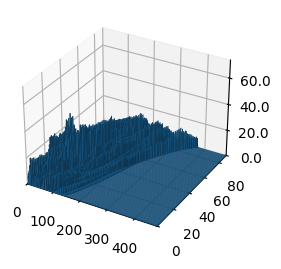

In [6]:
# Find maximum
maxH, _ = imageMaxMin(accHorizontal)
maxV, _ = imageMaxMin(accVertical)
maximum = max(maxH, maxV)
peakThreshold = peakDetection * maximum

plot3DHistogram(accHorizontal, [0,maximum])
plot3DHistogram(accVertical, [0,maximum])

### Peak detection

In [7]:
peakHorizontal = peakDetectorImageL(accHorizontal, peakThreshold)
peakVertical = peakDetectorImageL(accVertical, peakThreshold)

### Draw detected lines

In [8]:
# Prepare output image as a dark version of the input
outputImage = createScaleImageL(inputImage, 0.5)

# Draw lines on output image
for peakIndex in range(0,len(peakHorizontal)):
    m = (peakHorizontal[peakIndex])[0]
    c = (peakHorizontal[peakIndex])[1]     
    strength = int(255.0 * accHorizontal[m, c] / maximum)
    angle = ((-45 + m) * pi) / 180.0
    for x in range(0, width -1):
        y = int(c + tan(angle) * x)
        if y > 0 and y < height -1:
            outputImage[y,x] = strength
            outputImage[y+1,x] = strength
    
for peakIndex in range(0,len(peakVertical)):
    m = (peakVertical[peakIndex])[0]
    c = (peakVertical[peakIndex])[1]  
        
    strength = int(255.0 * accVertical[m, c] / maximum)
    angle = ((45 + m) * pi) / 180.0
    for y in range(0, height -1):
        x = int(c + y / tan(angle))
        if x > 0 and x < width -1:
            outputImage[y,x] = strength
            outputImage[y,x+1] = strength  
            

### Show image with detected lines

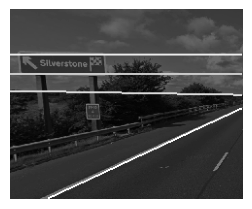

In [9]:
plotImageL(outputImage, figureSize = 3)